In [1]:
import cv2
import numpy as np
import pandas as pd
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount("/content/drive")

2.8.0
Mounted at /content/drive


In [2]:
path = "/content/drive/MyDrive/Deep_Learning/Face_Recognation/Material.zip"
zip_object = zipfile.ZipFile(file = path, mode = "r")
zip_object.extractall("./")
zip_object.close()

In [3]:
base_imgs = "/content/Material/fer2013.zip"
zip_object = zipfile.ZipFile(file = base_imgs, mode = "r")
zip_object.extractall("./")
zip_object.close()

# Accesing The Base With Photos Of Facial Expressions

In [4]:
data = pd.read_csv("/content/fer2013/fer2013.csv")
print("DataFrame Shape : ",data.shape)
data.tail()

DataFrame Shape :  (35887, 3)


,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


In [5]:
len(data["pixels"][0]),data["emotion"].unique(),data["Usage"].unique()

(8287,
 array([0, 2, 4, 6, 3, 5, 1]),
 array(['Training', 'PublicTest', 'PrivateTest'], dtype=object))

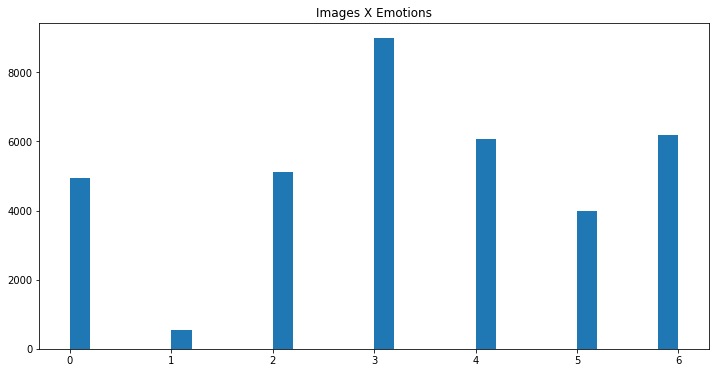

In [6]:
plt.figure(figsize =(12,6))
plt.hist(data["emotion"], bins = 30)
plt.title("Images X Emotions")
plt.show()

# PreProcessing

In [7]:
pixels = data["pixels"].tolist()
len(pixels)

35887

In [8]:
pixels[0]

'70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92

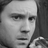

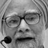

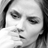

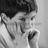

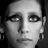

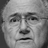

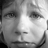

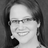

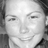

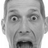

In [9]:
width,height = 48,48
faces = []
samples = 0
for pixel_squences in pixels:
    face = [int(pixel) for pixel in pixel_squences.split(" ")]
    face = np.asarray(face).reshape(width, height)
    faces.append(face)

    if (samples < 10):
        cv2_imshow(face)
    samples+=1

In [10]:
print("Total Number Of Images In Dataset : ",str(len(faces)))

Total Number Of Images In Dataset :  35887


In [11]:
type(np.array(faces)),np.array(faces).shape

(numpy.ndarray, (35887, 48, 48))

In [12]:
print("Before Faces Shape : ", np.array(faces).shape)
faces = np.expand_dims(faces,-1)
print("After Faces Shape : ", faces.shape)

Before Faces Shape :  (35887, 48, 48)
After Faces Shape :  (35887, 48, 48, 1)


In [13]:
def normalizer(x) : 
    x = x.astype("float32")
    x = x / 255.0
    return x

In [14]:
faces = normalizer(faces)
print("Face Max : ",faces.max())
print("Face Min : ",faces.min())

Face Max :  1.0
Face Min :  0.0


In [15]:
print("Emotion Unique : ", len(data["emotion"].unique()))
emotions = pd.get_dummies(data["emotion"]).values
emotions.shape

Emotion Unique :  7


(35887, 7)

# Tensorflow & Keras

In [16]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import Conv2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

In [17]:
X_train,X_test,y_train,y_test = train_test_split(faces,emotions,test_size = 0.1,random_state = 42)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.1,random_state = 42)

In [18]:
print('Number of images in the training set: ', len(X_train))
print('Number of images in the test set: ', len(X_test))
print('Number of images in the validation set: ', len(X_val))

Number of images in the training set:  29068
Number of images in the test set:  3589
Number of images in the validation set:  3230


In [19]:
np.save("mod_xtest",X_test)
np.save("mod_ytest",y_test)

# CNN

In [20]:
# kernel_initializer = "he_normal"
# activation = "elu"
# epochs ,num_featues,batch_size Increase or Decrease
# learning rate : Decrease Note : Have Some Problem To Encounter

num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48

model = Sequential()

model.add(Conv2D(filters = num_features, kernel_size = (3,3), activation = "relu",
                 input_shape = (width,height,1), data_format = "channels_last", kernel_regularizer = l2(0.01)))
model.add(Conv2D(filters = num_features, kernel_size = (3,3), activation = "relu", padding = "same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(rate = 0.5))

model.add(Conv2D(filters = 2*num_features, kernel_size = (3,3), activation = "relu",padding = "same"))
model.add(BatchNormalization())
model.add(Conv2D(filters = 2*num_features, kernel_size = (3,3), activation = "relu",padding = "same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(rate = 0.5))

model.add(Conv2D(filters = 2*2*num_features, kernel_size = (3,3), activation = "relu",padding = "same"))
model.add(BatchNormalization())
model.add(Conv2D(filters = 2*2*num_features, kernel_size = (3,3), activation = "relu",padding = "same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(rate = 0.5))

model.add(Conv2D(filters = 2*2*2*num_features, kernel_size = (3,3), activation = "relu",padding = "same"))
model.add(BatchNormalization())
model.add(Conv2D(filters = 2*2*2*num_features, kernel_size = (3,3), activation = "relu",padding = "same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(rate = 0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features,activation = "relu"))
model.add(Dropout(rate = 0.4))
model.add(Dense(2*2*num_features,activation = "relu"))
model.add(Dropout(rate = 0.4))
model.add(Dense(2*num_features,activation = "relu"))
model.add(Dropout(rate = 0.5))

model.add(Dense(num_labels,activation = "softmax"))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 128)       7

# Compile and Train

In [21]:
model.compile(loss = "categorical_crossentropy",
              optimizer = Adam(lr = 0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics = ["accuracy"])

file_model = "model_01_expressions.h5"
json_file_model = "model_01_expressions.json"

lr_reducer = ReduceLROnPlateau(monitor = "val_loss", factor = 0.9, patience = 3 , verbose = 1)
early_stopper = EarlyStopping(monitor = "val_loss",min_delta = 0, patience = 8, verbose = 1, mode = "auto")
checkpointer = ModelCheckpoint(file_model,monitor = "val_loss",verbose = 1, save_best_only = True) 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [22]:
model_json = model.to_json()
with open(json_file_model , "w") as json_file:
    json_file.write(model_json)
json_file.close()

In [23]:
history = model.fit(np.array(X_train), np.array(y_train),
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = (np.array(X_val),np.array(y_val)),
                    shuffle = True,
                    callbacks = [lr_reducer,early_stopper,checkpointer])

Epoch 1/100
455/455 [==============================] - ETA: 0s - loss: 1.9907 - accuracy: 0.2139
Epoch 1: val_loss improved from inf to 1.83512, saving model to model_01_expressions.h5
455/455 [==============================] - 33s 46ms/step - loss: 1.9907 - accuracy: 0.2139 - val_loss: 1.8351 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 2/100
455/455 [==============================] - ETA: 0s - loss: 1.8335 - accuracy: 0.2414
Epoch 2: val_loss improved from 1.83512 to 1.80777, saving model to model_01_expressions.h5
455/455 [==============================] - 19s 43ms/step - loss: 1.8335 - accuracy: 0.2414 - val_loss: 1.8078 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 3/100
455/455 [==============================] - ETA: 0s - loss: 1.7963 - accuracy: 0.2627
Epoch 3: val_loss did not improve from 1.80777
455/455 [==============================] - 19s 43ms/step - loss: 1.7963 - accuracy: 0.2627 - val_loss: 2.0128 - val_accuracy: 0.2563 - lr: 0.0010
Epoch 4/100
454/455 [=======================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


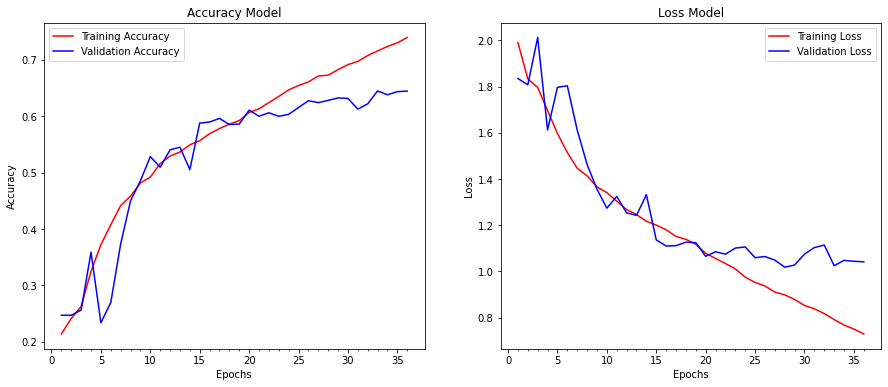

In [26]:
def history_graph(history):

    fig,ax = plt.subplots(1,2,figsize =(15,6))
    ax[0].plot(range(1,len(history.history["accuracy"]) + 1), history.history["accuracy"],"r")
    ax[0].plot(range(1,len(history.history["val_accuracy"]) + 1), history.history["val_accuracy"],"b")
    ax[0].set_title("Accuracy Model")
    ax[0].set_ylabel("Accuracy")
    ax[0].set_xlabel("Epochs")
    ax[0].set_xticks(np.arange(1,len(history.history["accuracy"]) + 1),
                     len(history.history["accuracy"]) / 10)
    
    ax[0].legend(["Training Accuracy", "Validation Accuracy"])
    
    ax[1].plot(range(1,len(history.history["loss"]) + 1), history.history["loss"],"r")
    ax[1].plot(range(1,len(history.history["val_loss"]) + 1), history.history["val_loss"],"b")
    ax[1].set_title("Loss Model")
    ax[1].set_ylabel("Loss")
    ax[1].set_xlabel("Epochs")
    ax[1].set_xticks(np.arange(1,len(history.history["loss"]) + 1),
                     len(history.history["loss"]) / 10)
    
    ax[1].legend(["Training Loss", "Validation Loss"])

history_graph(history)

In [27]:
scores = model.evaluate(np.array(X_test), np.array(y_test), batch_size = batch_size)
print("Accuracy: " , scores[1])
print("Loss: " , scores[0])

57/57 [==============================] - 1s 23ms/step - loss: 1.0841 - accuracy: 0.6336
Accuracy:  0.6336026787757874
Loss:  1.0841405391693115


In [28]:
true_y = []
pred_y = []
x = np.load("/content/mod_xtest.npy")
y = np.load("/content/mod_ytest.npy")
x.shape,y.shape

((3589, 48, 48, 1), (3589, 7))

In [29]:
json_file = open(json_file_model,"r")
loaded_model_json = json_file.read()
json_file.close()

In [30]:
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(file_model)

In [33]:
loaded_model.compile(loss = "categorical_crossentropy",
                     optimizer = Adam(lr = 0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
                     metrics = ["accuracy"])

scores = loaded_model.evaluate(np.array(X_test), np.array(y_test), batch_size = batch_size)

print("Accuracy: " , scores[1])
print("Loss: " , scores[0])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


57/57 [==============================] - 2s 16ms/step - loss: 1.0554 - accuracy: 0.6236
Accuracy:  0.623572051525116
Loss:  1.0553791522979736


In [37]:
y_pred = loaded_model.predict(x)
y_p = y_pred.tolist()
y_t = y.tolist()
count = 0

In [38]:
len(y)

3589

In [40]:
for i in range(len(y)):
    yy = max(y_p[i])
    yyt = max(y_t[i])
    pred_y.append(y_p[i].index(yy))
    true_y.append(y_t[i].index(yyt))
    if (y_p[i].index(yy) == y_t[i].index(yyt)):
        count+=1

acc = (count / len(y)) * 100
print("Accuracy Test : ",str(acc))

Accuracy Test :  62.35720256338813


In [41]:
np.save("true_y_mod01",true_y)
np.save("pred_y_mod01",pred_y)

# Confusion Matrix

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [44]:
y_true = np.load("true_y_mod01.npy")
y_pred = np.load("pred_y_mod01.npy")

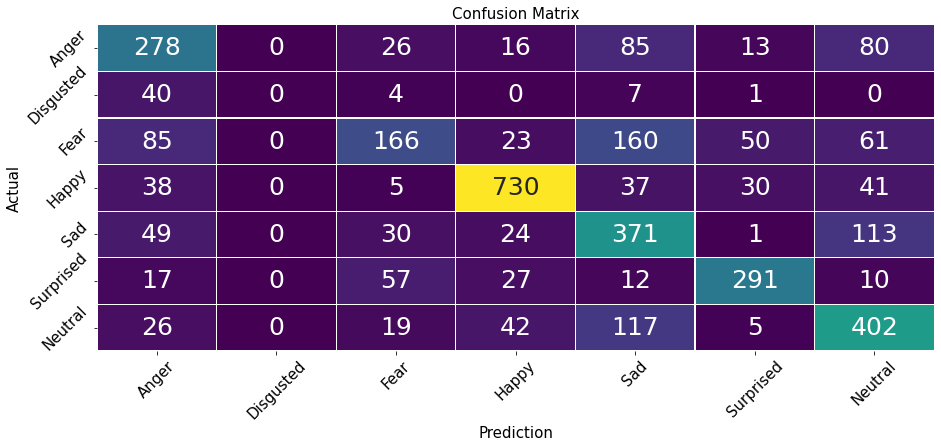

In [66]:
from pyparsing.util import line
expressions = ['Anger', 'Disgusted', 'Fear', 'Happy', 'Sad', 'Surprised', 'Neutral']

def confusion_matrix_graph(y_true,y_pred,label):
    cm = confusion_matrix(y_true,y_pred)
    size = 15

    plt.figure(figsize = (15,6))
    sns.heatmap(cm,annot=True,fmt = "d",cmap = "viridis", cbar = False, xticklabels=label,yticklabels = label,
                linecolor="white",linewidths=.2,annot_kws = {"size":25,})
    

    plt.title("Confusion Matrix",fontsize = size)
    plt.ylabel("Actual",fontsize = size)
    plt.xlabel("Prediction",fontsize = size)
    plt.yticks(rotation = 45,fontsize = size)
    plt.xticks(rotation = 45,fontsize = size)
    plt.show()

confusion_matrix_graph(y_true,y_pred,expressions)

# Test

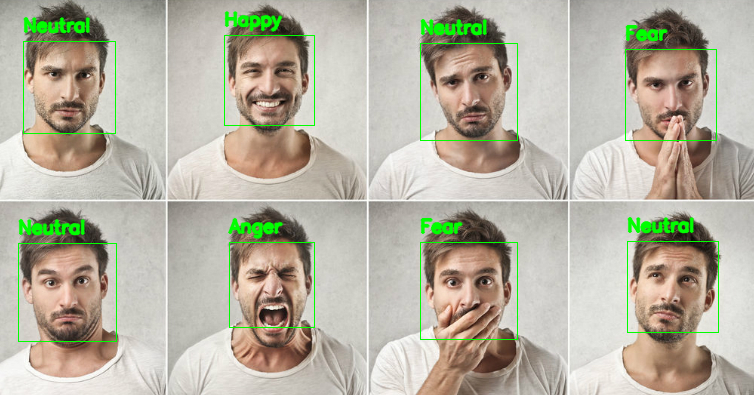

In [70]:
face_cascade = cv2.CascadeClassifier("/content/Material/haarcascade_frontalface_default.xml")
expressions = ['Anger', 'Disgusted', 'Fear', 'Happy', 'Sad', 'Surprised', 'Neutral']

img = cv2.imread("/content/Material/testes/teste02.jpg")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray,1.1,3)

for x,y,w,h in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),1)
    roi_gray = gray[y:y+h,x:x+w]
    roi_gray = roi_gray.astype("float") / 255.0
    resize = cv2.resize(roi_gray,(48,48))
    cropped_img = np.expand_dims(np.expand_dims(resize,-1), 0)
    prediction = loaded_model.predict(cropped_img)[0]

    label = expressions[int(np.argmax(prediction))]

    cv2.putText(img,label,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,255,0),2,cv2.LINE_AA)

cv2_imshow(img)